# Imports, loading and downloads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from loads import *
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

PATH_FOLDER = "MovieSummaries/"

In [2]:
# Loading character metadata DataFrame
character_df = load_character_metadata()
# Loading movie metadata DataFrame
movie_df = load_movie_metadata()
# Loading plot summaries DataFrame
plot_summaries_df = load_plot_summaries()
# Loading TVTropes DataFrame
tvtropes_df = load_tvtropes()
# Loading name clusters DataFrame
name_clusters_df = load_name_clusters()
# Loading inflation DataFrame
inflation = pd.read_excel("external_dataset/inflation.xlsx", header=11)

/Users/ahmedaziz/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# Preprocessing

## CLEANING

#### MOVIE METADATA Cleaning

We are first extracting variables that have the form (ID : variable) tuples to be able to use these features.

In [3]:
# Extracting and transforming the 'Movie languages (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of language names
movie_df['Movie Languages'] = movie_df['Movie languages (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))
# Extracting and transforming the 'Movie countries (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of country names
movie_df['Movie Countries'] = movie_df['Movie countries (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))
# Extracting and transforming the 'Movie genres (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of genre names
movie_df['Movie Genres'] = movie_df['Movie genres (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))

A lot of columns in the dataframe contain IDs that we don't need, we are thus, dropping them.

In [4]:
# List of columns to be dropped from the DataFrame
movie_columns_to_drop = ['Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)','Movie genres (Freebase ID:name tuples)','Freebase movie ID']
# Dropping specified columns from the DataFrame
movie_df.drop(movie_columns_to_drop, axis=1, inplace=True)

Our main interest is to see what features result in higher boxe office revenues, so we need to drop movies with missing revenue (Nan).

In [5]:
# Dropping rows from the DataFrame where 'Movie box office revenue' is NaN
movie_df.dropna(subset=['Movie box office revenue'], inplace=True)

One of our feature of interest is the release date of the movies. We are thus, processing the column, for it to be usable in our analysis. We extract Year and Month from the Movie release date (date format YYYY and YYYY-MM-DD can't be dealt together).

In [6]:
# Dropping rows where 'Movie release date' is NaN
movie_df.dropna(subset=["Movie release date"], inplace=True)
# Create a Year column in the movie dataframe
movie_df['Year'] = movie_df["Movie release date"].apply(lambda x: str(x)[:4]).astype(int)
# Create a Month column in the movie dataframe
movie_df['Month'] = pd.to_datetime(movie_df['Movie release date'],errors='coerce').dt.month

## Inflation

To be able to compare the relative box office revenues across different years, we need to take inflation into account.

In [7]:
# Calculate cumulative inflation to 2022 using the last available annual inflation rate
inflation["Cumulative Inflation to 2022"] = inflation.iloc[-1].Annual / inflation["Annual"]
# Merge the movie DataFrame with the inflation DataFrame on the 'Year' column
movie_with_inflation = pd.merge(movie_df, inflation, on='Year')
# Calculate revenue with inflation by multiplying 'Movie box office revenue' with the 'Cumulative Inflation to 2022'
movie_with_inflation['Revenue with inflation'] = movie_with_inflation['Movie box office revenue'] * movie_with_inflation['Cumulative Inflation to 2022']
movie_with_inflation.drop(['Cumulative Inflation to 2022', 'Annual'], axis=1, inplace=True)

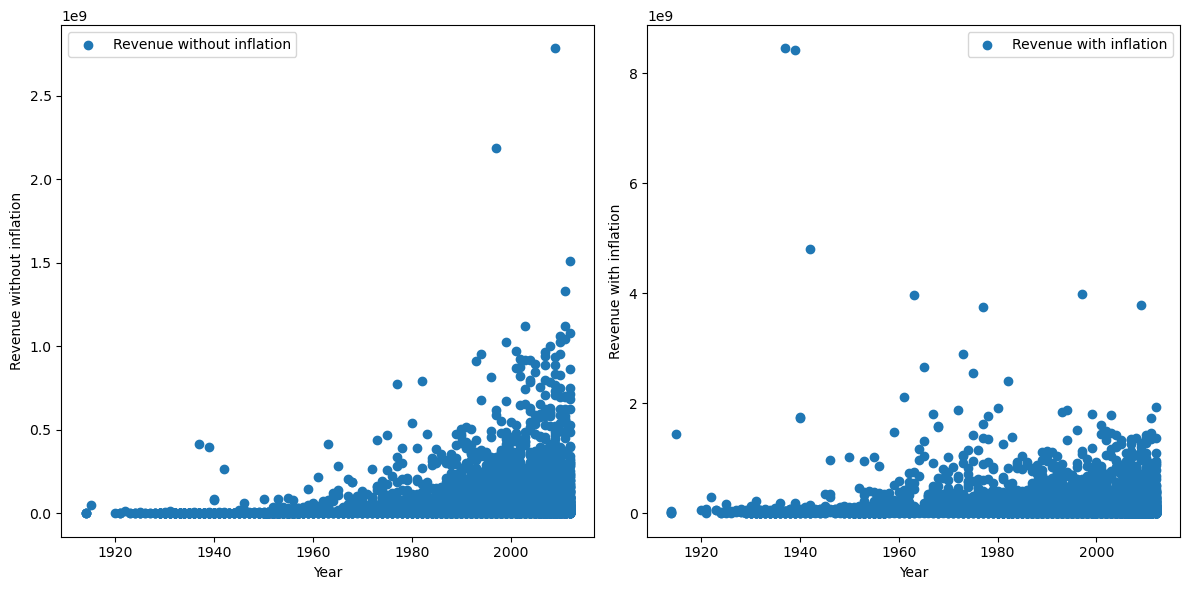

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot for Revenue without inflation
ax1.scatter(movie_with_inflation['Year'], movie_with_inflation['Movie box office revenue'], label='Revenue without inflation')
ax1.set_xlabel('Year')
ax1.set_ylabel('Revenue without inflation')
ax1.legend()

# Plot for Revenue with inflation
ax2.scatter(movie_with_inflation['Year'], movie_with_inflation['Revenue with inflation'], label='Revenue with inflation')
ax2.set_xlabel('Year')
ax2.set_ylabel('Revenue with inflation')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

The original distribution of the inflated movie box office revenue exhibits a heavy-tailed pattern, with a few movies achieving extremely high revenues. By applying a logarithmic transformation on the x-axis, we approximate a "more" normal distribution, making the data more amenable to statistical analyses that assume normality.

Text(0, 0.5, 'Number of movies')

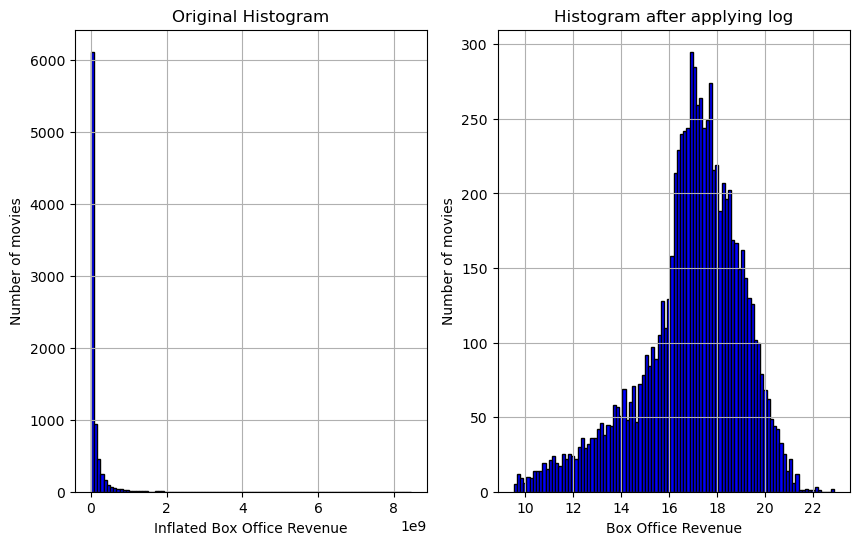

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plotting the original distribution and the distribution after applying log function on the revenue feature
movie_with_inflation['Revenue with inflation'].hist(ax=axs[0], bins=100, color='blue', edgecolor='black')
movie_with_inflation['log_revenues'] = np.log(movie_with_inflation['Revenue with inflation'])
movie_with_inflation['log_revenues'].hist(ax=axs[1], bins=100, color='blue', edgecolor='black')
axs[0].set_title('Original Histogram')
axs[0].set_xlabel('Inflated Box Office Revenue')
axs[0].set_ylabel('Number of movies')
axs[1].set_title('Histogram after applying log')
axs[1].set_xlabel('Box Office Revenue')
axs[1].set_ylabel('Number of movies')

#### CHARACTER METADATA Cleaning

Again, a lot of columns in the dataframe contain IDs that we don't need, as well as actors' heights, we are thus, dropping them.

In [10]:
# Dropping unnecessary character-related columns from the DataFrame
character_columns_to_drop = ['Freebase movie ID', 'Actor ethnicity (Freebase ID)','Freebase character ID','Freebase actor ID','Actor height (in meters)']
character_df.drop(character_columns_to_drop, axis=1, inplace=True)

The plot summaries, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

## Splitting

We are now splitting the dataframes into many small different dataframes for each feature. Each small df has one feature and 'log_revenues'. These small dataframes are created for the analysis to be easier.

In [11]:
# Extracting 'Movie runtime' and 'log_revenues' columns into a new dataframe
movie_runtime_df = movie_with_inflation[['Movie runtime', 'log_revenues', 'Revenue with inflation']].copy()
# Extracting 'Movie Languages' and 'log_revenues' columns into a new dataframe
movie_languages_df = movie_with_inflation[['Movie Languages', 'log_revenues', 'Revenue with inflation']].copy()
# Extracting 'Movie Countries' and 'log_revenues' columns into a new dataframe
movie_countries_df = movie_with_inflation[['Movie Countries', 'log_revenues', 'Revenue with inflation']].copy()
# Extracting 'Movie Genres' and 'log_revenues' columns into a new dataframe
movie_genres_df = movie_with_inflation[['Movie Genres', 'log_revenues', 'Revenue with inflation']].copy()
# Extracting 'Month' and 'log_revenues' columns into a new dataframe
months_df = movie_with_inflation[['Month', 'log_revenues', 'Revenue with inflation']].copy()
# Extracting 'Year' and 'log_revenues' columns into a new dataframe
years_df = movie_with_inflation[['Year', 'log_revenues', 'Revenue with inflation']].copy()

Drop movies in each small dataframe, only for the missing values (Nan) of the concerned feature

In [12]:
# Drop NaNs in each small dataframes
movie_runtime_df.dropna(subset=['Movie runtime'], inplace=True)
movie_languages_df.dropna(subset=['Movie Languages'], inplace=True)
movie_countries_df.dropna(subset=['Movie Countries'], inplace=True)
movie_genres_df.dropna(subset=['Movie Genres'], inplace=True)
years_df.dropna(subset=['Year'], inplace=True) #no nan but safer
months_df.dropna(subset=['Month'], inplace=True)

We then need to merge character and movie dataframes, to be able to extract information on actors and their impact on box office revenues

In [13]:
# Merging character_df and movie_with_inflation DataFrames on 'Wikipedia movie ID'
# Dropping the 'Movie release date' column from character_df to avoid duplicate columns after the merge
character_movie_merged_df = pd.merge(character_df.drop(['Movie release date'],axis=1), movie_with_inflation, on=['Wikipedia movie ID'])

One of our features will be the percentage of women actresses in movies, so we need to get this information

In [14]:
# Create a new DataFrame containing relevant columns from the original DataFrame
actor_gender_movie_df = character_movie_merged_df[['Movie name','log_revenues','Actor name','Actor gender', 'Revenue with inflation']].copy()
# Drop rows with missing values
actor_gender_movie_df.dropna(inplace=True)
# Compute percentage of women in each movies
actor_gender_movie_df['Percentage Women'] = (actor_gender_movie_df.groupby('Movie name')['Actor gender']
                                              .transform(lambda x: (x == 'F').mean() * 100)
                                              .fillna(0)  # Fill NaN with 0
                                              .astype(int)  # Ensure the column is of int type
                                             )

In [15]:
# Creating a DataFrame with actor gender, actor name, and log_revenues from the merged DataFrame
actor_gender_df = actor_gender_movie_df[['Percentage Women','Actor name','log_revenues', 'Revenue with inflation']].copy()
# Removing duplicate rows from actor_gender_df based on all columns
actor_gender_df.drop_duplicates()
# Creating a new DataFrame with percentage women and log_revenues, dropping rows with missing percentage women
gender_df = actor_gender_df[['Percentage Women','log_revenues', 'Revenue with inflation']].copy()
gender_df.dropna(subset=['Percentage Women'], inplace=True)

In [16]:
# Creating a DataFrame with actor name, actor age at movie release, and log_revenues from the merged DataFrame
actor_df = character_movie_merged_df[['Actor name','Actor age at movie release','log_revenues', 'Revenue with inflation']].copy()
actor_df.dropna()

,Actor name,Actor age at movie release,log_revenues,Revenue with inflation
0,Wanda De Jesus,42.0,16.957621,2.315268e+07
1,Natasha Henstridge,27.0,16.957621,2.315268e+07
2,Ice Cube,32.0,16.957621,2.315268e+07
3,Jason Statham,33.0,16.957621,2.315268e+07
4,Clea DuVall,23.0,16.957621,2.315268e+07
...,...,...,...,...
100848,Roland Culver,64.0,17.746917,5.097861e+07
100849,Michael Hordern,53.0,17.746917,5.097861e+07
100850,Reginald Beckwith,56.0,17.746917,5.097861e+07
100851,Gong Yoo,32.0,17.503715,3.997302e+07


# Percentage pos / neg

In [17]:
movie_summaries = plot_summaries_df.copy()

#Extract each column in a new Series variables
Movie_IDs = movie_summaries["Movie ID"].squeeze()
Movie_Summaries = movie_summaries["Movie Summary"].squeeze()

#Check uniqueness of values in each Series variable
print(Movie_IDs.duplicated().sum()) # contains 0 duplicate values
print(Movie_Summaries.duplicated().sum()) # contains 8 duplicate values

#Remove duplicate values
summary_metadata = movie_summaries.drop_duplicates("Movie Summary")
print(summary_metadata.shape)

0
8
(42295, 2)


In [18]:
#function used to tokenize into dataframe columns into single words
def tokenize(column):
    """Tokenizes a Pandas dataframe column and returns a list of tokens.

    Args:
        column: Pandas dataframe column.

    Returns:
        tokens (list): Tokenized list.
    """

    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()] 

In [19]:
#add a column containing tokenized summaries
summary_metadata['tokenized_summary'] = summary_metadata.apply(lambda x: tokenize(x['Movie Summary']), axis=1)

summary_metadata

/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_2481/446396839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_metadata['tokenized_summary'] = summary_metadata.apply(lambda x: tokenize(x['Movie Summary']), axis=1)


,Movie ID,Movie Summary,tokenized_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a, taxi, driver, and, Lyosha, a, sax..."
1,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla..."
...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","[The, story, is, about, Reema, a, young, Musli..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","[In, Hollywood, director, Leo, Andreyev, looks..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,"[American, Luthier, focuses, on, Randy, Parson..."
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","[Abdur, Rehman, Khan, a, dry, fruit, seller, f..."


In [22]:
#filter the column containing tokenized text by deleting all stopwords
summary_metadata['filtered_Tokens'] = summary_metadata['tokenized_summary'].apply(lambda tokens: [word.lower() for word in tokens if word.lower() not in stop_words])

summary_metadata

/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_2481/921045962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_metadata['filtered_Tokens'] = summary_metadata['tokenized_summary'].apply(lambda tokens: [word.lower() for word in tokens if word.lower() not in stop_words])


,Movie ID,Movie Summary,tokenized_summary,filtered_Tokens
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a, taxi, driver, and, Lyosha, a, sax...","[shlykov, taxi, driver, lyosha, saxophonist, d..."
1,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal...","[nation, panem, consists, wealthy, capitol, tw..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si...","[poovalli, induchoodan, sentenced, six, years,..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw...","[lemon, drop, kid, new, york, city, swindler, ..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla...","[adventist, church, pastor, michael, chamberla..."
...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","[The, story, is, about, Reema, a, young, Musli...","[story, reema, young, muslim, schoolgirl, mala..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","[In, Hollywood, director, Leo, Andreyev, looks...","[hollywood, director, leo, andreyev, looks, ph..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,"[American, Luthier, focuses, on, Randy, Parson...","[american, luthier, focuses, randy, parsons, t..."
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","[Abdur, Rehman, Khan, a, dry, fruit, seller, f...","[abdur, rehman, khan, dry, fruit, seller, afgh..."


In [23]:
#Initialize an empty list to store percentage of positive, negative and neutral words in each row of the 'filtered_Tokens' column 
positive_scores = []
negative_scores = []
neutral_scores = []
sentiment_scores = []

#Perform sentiment analysis on each word
for liss in summary_metadata['filtered_Tokens'][:] :
  nbr_words_pos = 0
  nbr_words_neg = 0
  nbr_words_neu = 0
  nbr_words = 0

  for word in liss:
    nbr_words+= 1
    blob = TextBlob(word)
    #perform sentiment polarities of the word
    if (blob.sentiment.polarity > 0):
        nbr_words_pos += 1
    elif (blob.sentiment.polarity < 0):
        nbr_words_neg += 1
    else:
        nbr_words_neu += 1
    
  positive_scores.append(nbr_words_pos/nbr_words)
  negative_scores.append(nbr_words_neg/nbr_words)
  neutral_scores.append(nbr_words_neu/nbr_words)

In [24]:
#create columns to store percentage of positive, negative and neutral words in each row of the 'filtered_Tokens' column
summary_metadata["percentage of positive words"] = positive_scores
summary_metadata["percentage of negative words"] = negative_scores
summary_metadata["percentage of neutral words"] = neutral_scores
summary_metadata.head(5)

/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_2481/4148968840.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_metadata["percentage of positive words"] = positive_scores
/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_2481/4148968840.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_metadata["percentage of negative words"] = negative_scores
/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_2481/4148968840.py:4: SettingWithCopyWarning: 
A value is trying 

,Movie ID,Movie Summary,tokenized_summary,filtered_Tokens,percentage of positive words,percentage of negative words,percentage of neutral words
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a, taxi, driver, and, Lyosha, a, sax...","[shlykov, taxi, driver, lyosha, saxophonist, d...",0.083333,0.000000,0.916667
1,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal...","[nation, panem, consists, wealthy, capitol, tw...",0.037296,0.027972,0.934732
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si...","[poovalli, induchoodan, sentenced, six, years,...",0.046099,0.046099,0.907801
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw...","[lemon, drop, kid, new, york, city, swindler, ...",0.061269,0.041575,0.897155
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla...","[adventist, church, pastor, michael, chamberla...",0.054726,0.039801,0.905473


In [101]:
summary_data = summary_metadata[["Movie ID","percentage of positive words","percentage of negative words","percentage of neutral words"]].copy()
movie_revenue_df = movie_with_inflation[["Wikipedia movie ID","Revenue with inflation","log_revenues"]].copy()
movie_revenue_df = movie_revenue_df.rename(columns={"Wikipedia movie ID":"Movie ID"})

pos_neg_df = movie_revenue_df.merge(summary_data,on="Movie ID")
pos_neg_df

,Movie ID,Revenue with inflation,log_revenues,percentage of positive words,percentage of negative words,percentage of neutral words
0,975900,2.315268e+07,16.957621,0.015152,0.055556,0.929293
1,156558,4.855272e+07,17.698161,0.051672,0.024316,0.924012
2,5566878,7.559723e+06,15.838345,0.052632,0.031579,0.915789
3,570743,1.176346e+08,18.583094,0.072243,0.034221,0.893536
4,366111,2.331158e+08,19.267046,0.054645,0.043716,0.901639
...,...,...,...,...,...,...
7523,26018309,4.230747e+07,17.560474,0.040441,0.051471,0.908088
7524,68388,1.653418e+07,16.620940,0.035813,0.030303,0.933884
7525,4499436,6.584737e+07,18.002850,0.044248,0.097345,0.858407
7526,1995966,8.557164e+07,18.264864,0.093333,0.013333,0.893333


/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_2481/2621979547.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x='pos_Interval', y='Revenue with inflation', data=pos_neg_df, ci=95)
/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_2481/2621979547.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x='neg_Interval', y='Revenue with inflation', data=pos_neg_df, ci=95)


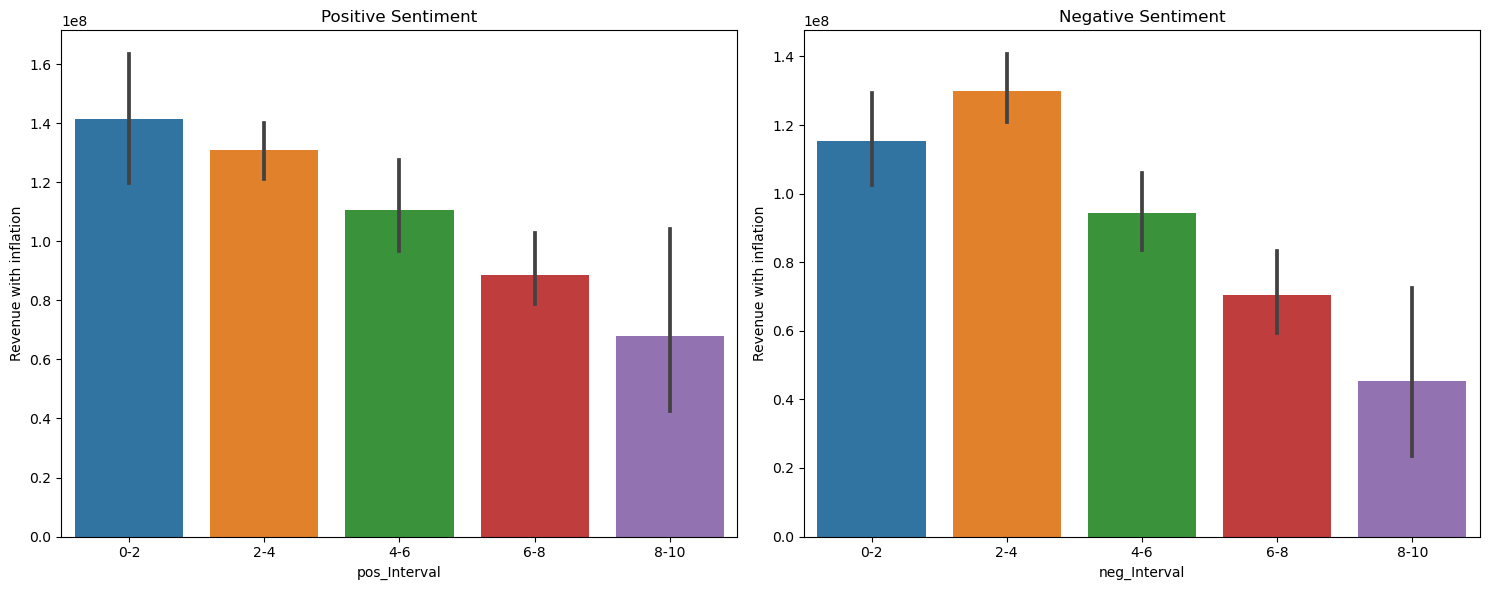

In [114]:
columns_of_interest = ['percentage of positive words', 'percentage of negative words', 'percentage of neutral words', 'Revenue with inflation']
data_to_plot = pos_neg_df[columns_of_interest]

# Set the figure size for the plot
plt.figure(figsize=(15, 6))

# Create subplots in a horizontal arrangement
plt.subplot(1, 2, 1)
pos_neg_df['pos_Interval'] = pd.cut(pos_neg_df['percentage of positive words'], bins=[0, 0.02, 0.04, 0.05, 0.08, 0.1], labels=['0-2', '2-4', '4-6', '6-8', '8-10'])

sns.barplot(x='pos_Interval', y='Revenue with inflation', data=pos_neg_df, ci=95)
plt.title('Positive Sentiment')

plt.subplot(1, 2, 2)
pos_neg_df['neg_Interval'] = pd.cut(pos_neg_df['percentage of negative words'], bins=[0, 0.02, 0.04, 0.05, 0.08, 0.1], labels=['0-2', '2-4', '4-6', '6-8', '8-10'])

sns.barplot(x='neg_Interval', y='Revenue with inflation', data=pos_neg_df, ci=95)
plt.title('Negative Sentiment')



# Adjust layout for better presentation
plt.tight_layout()

# Show the plots
plt.show()

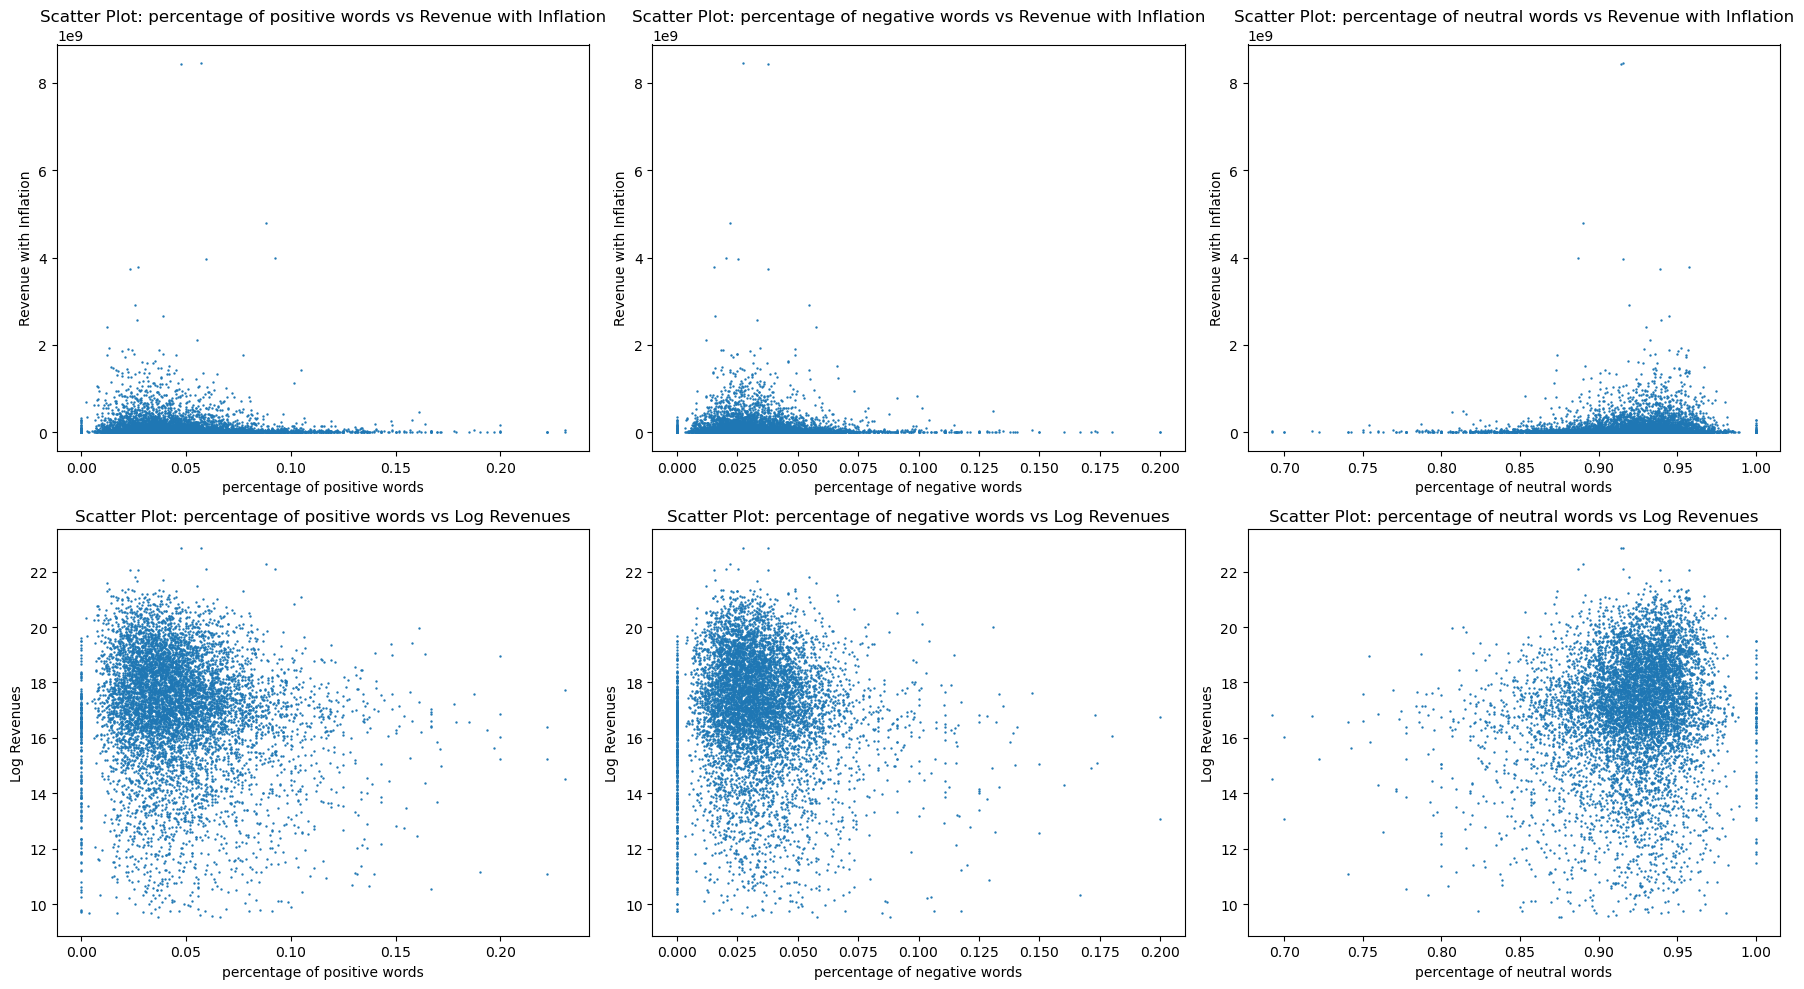

In [28]:
# Example x-axis labels
x_axis = ["percentage of positive words", "percentage of negative words", "percentage of neutral words"]


# Create a new column for intervals
movie_runtime['Interval'] = pd.cut(movie_runtime['Movie runtime'], bins=[0, 60, 120, 180, 240, 1000], labels=['0-60', '60-120', '120-180', '180-240', '240-1000'])

# Set up a multi-plot grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the mean revenue with error bars and 95% confidence interval
sns.barplot(x='Interval', y='Revenue with inflation', data=movie_runtime, ci=95, capsize=.2, palette='viridis', ax=ax1)
ax1.set_title('Mean Revenue for Each Runtime Interval')
ax1.set_xlabel('Runtime Interval')
ax1.set_ylabel('Mean Revenue')



# Create a figure with six subplots (2 rows and 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Flatten the 2D array of axes for easier indexing in the loop
axes = axes.flatten()

# Loop through each subplot
for i in range(len(x_axis)):
    # Scatter plot for 'percentage of positive words' vs 'Revenue with inflation'
    axes[i].scatter(pos_neg_df[x_axis[i]], pos_neg_df['Revenue with inflation'], s=0.5)
    axes[i].set_xlabel(x_axis[i])
    axes[i].set_ylabel('Revenue with Inflation')
    axes[i].set_title(f'Scatter Plot: {x_axis[i]} vs Revenue with Inflation')

    # Scatter plot for 'percentage of positive words' vs 'log_revenues'
    axes[i + 3].scatter(pos_neg_df[x_axis[i]], pos_neg_df['log_revenues'], s=0.5)
    axes[i + 3].set_xlabel(x_axis[i])
    axes[i + 3].set_ylabel('Log Revenues')
    axes[i + 3].set_title(f'Scatter Plot: {x_axis[i]} vs Log Revenues')

# Adjust layout for better presentation
plt.tight_layout()

# Show the plots
plt.show()

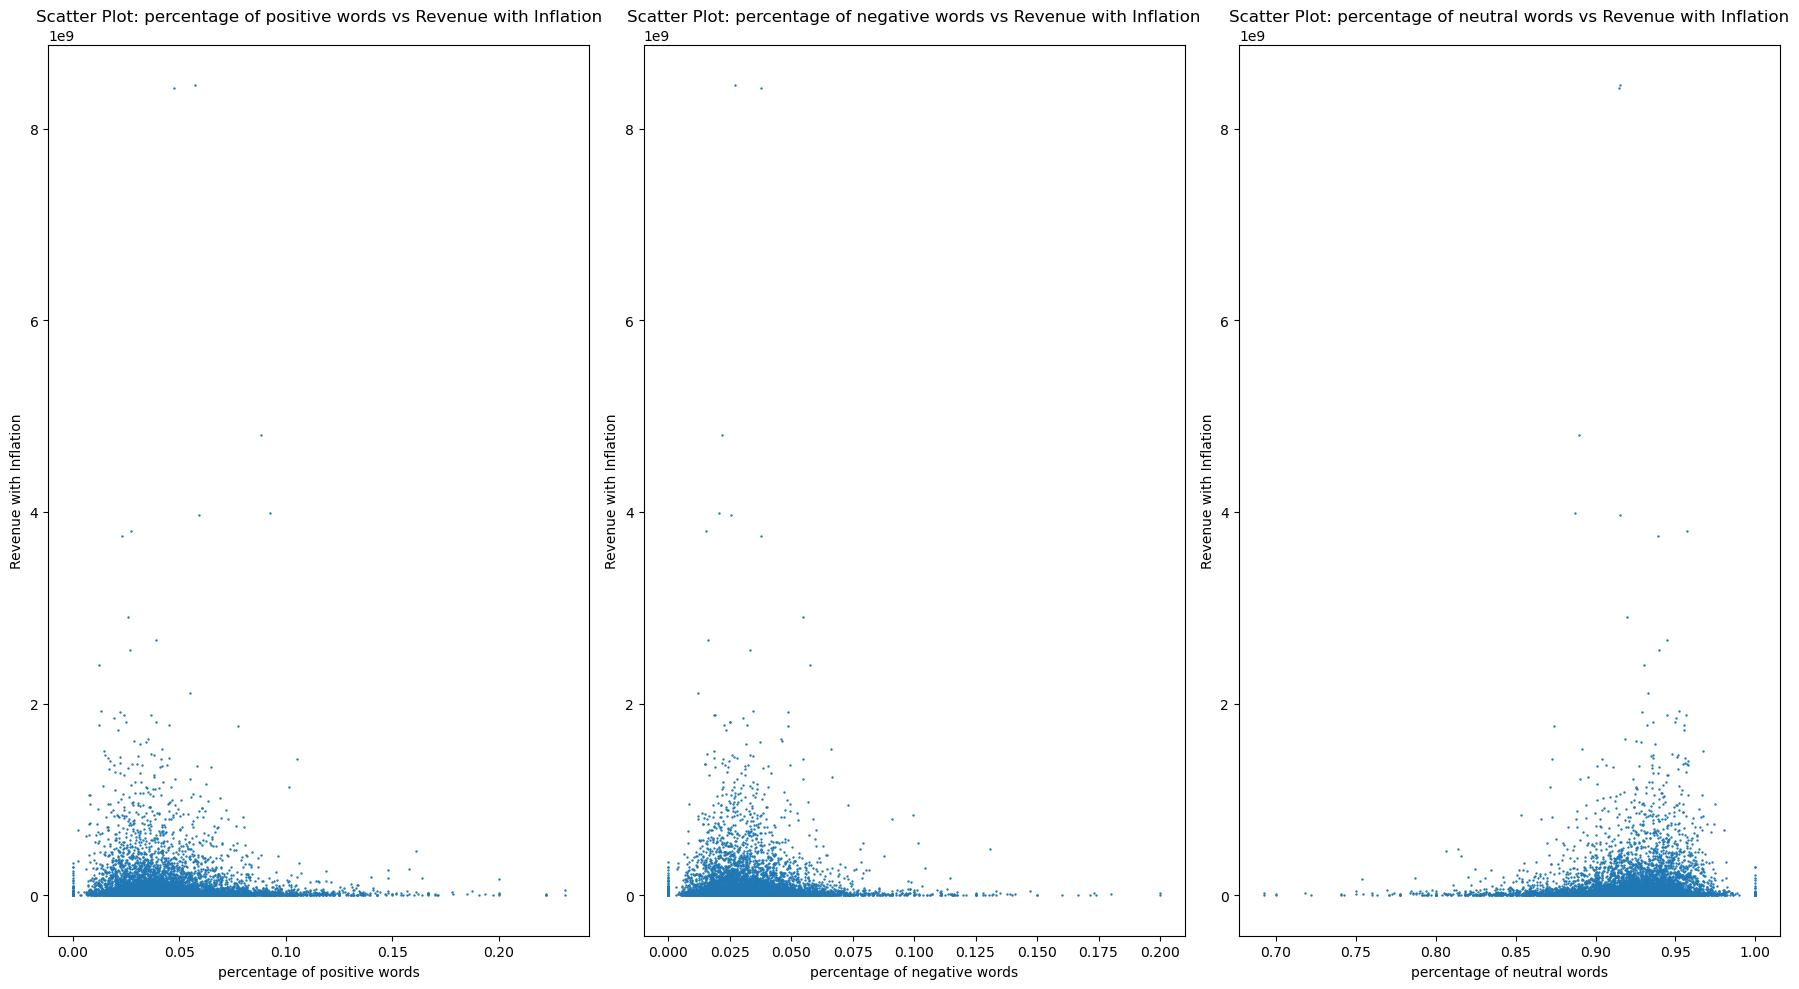

In [29]:
# Example x-axis labels
x_axis = ["percentage of positive words", "percentage of negative words", "percentage of neutral words"]

# Create a figure with six subplots (2 rows and 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# Flatten the 2D array of axes for easier indexing in the loop
axes = axes.flatten()

# Loop through each subplot
for i in range(len(x_axis)):
    # Scatter plot for 'percentage of positive words' vs 'Revenue with inflation'
    axes[i].scatter(pos_neg_df[x_axis[i]], pos_neg_df['Revenue with inflation'], s=0.5)
    axes[i].set_xlabel(x_axis[i])
    axes[i].set_ylabel('Revenue with Inflation')
    axes[i].set_title(f'Scatter Plot: {x_axis[i]} vs Revenue with Inflation')

# Adjust layout for better presentation
plt.tight_layout()

# Show the plots
plt.show()

In [30]:
# From the graph, we can extract a threshold for the positive percentage of words
pos_thres = 0.1

# Filter movies which have positive percentage of words > 10%
pos_total_df = pos_neg_df[pos_neg_df["percentage of positive words"]> pos_thres]
# Filter movies which have positive percentage of words <= 10%
non_pos_total_df = pos_neg_df[pos_neg_df["percentage of positive words"]<= pos_thres]

# From the graph, we can extract a threshold for the negative percentage of words
neg_thres = 0.075
# Filter movies which have negative percentage of words > 7.5%
neg_total_df = pos_neg_df[pos_neg_df["percentage of negative words"]> neg_thres]
# Filter movies which have positive percentage of words <= 7.5%
non_neg_total_df = pos_neg_df[pos_neg_df["percentage of negative words"]<= neg_thres]

In [32]:
from scipy.stats import ttest_ind

# Extract the numerical data from the DataFrames
data_pos_total = pos_total_df["log_revenues"]
data_non_pos_total = non_pos_total_df["log_revenues"]

# Run the t-test
t_statistic, p_value = ttest_ind(data_pos_total, data_non_pos_total)

# Print the results
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

# Check the significance level
alpha = 0.05
if p_value < alpha:
    print('The difference is statistically significant (reject the null hypothesis)')
else:
    print('The difference is not statistically significant (fail to reject the null hypothesis)')


T-statistic: -8.995709969812653
P-value: 2.9284733056463813e-19
The difference is statistically significant (reject the null hypothesis)


In [33]:
# Extract the numerical data from the DataFrames
data_neg_total = neg_total_df["log_revenues"]
data_non_neg_total = non_neg_total_df["log_revenues"]

# Run the t-test
t_statistic, p_value = ttest_ind(data_neg_total, data_non_neg_total)

# Print the results
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

# Check the significance level
alpha = 0.05
if p_value < alpha:
    print('The difference is statistically significant (reject the null hypothesis)')
else:
    print('The difference is not statistically significant (fail to reject the null hypothesis)')


T-statistic: -7.806942685490667
P-value: 6.650874184964662e-15
The difference is statistically significant (reject the null hypothesis)


We can see that there is no statistically significant difference for both comparing data with high and low positive percentages and data with high and low negative percentages, which shows that positive and negative percentages can be used as part of the final estimator for movie revenue

# OLS + INTERPRETATION TO BE ADDED

In [34]:
# Rename the column
pos_neg_df = pos_neg_df.rename(columns={'Revenue with inflation': 'Revenue_with_inflation', "percentage of positive words": "percentage_of_positive_words",
                                           "percentage of negative words": "percentage_of_negative_words", "percentage of neutral words": "percentage_of_neutral_words"})

mod_pos_neg = smf.ols(formula='log_revenues ~ percentage_of_positive_words * percentage_of_negative_words * percentage_of_neutral_words', data=pos_neg_df)
res_pos_neg = mod_pos_neg.fit()
print(res_pos_neg.summary())

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     49.79
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           2.56e-60
Time:                        11:07:23   Log-Likelihood:                -16173.
No. Observations:                7528   AIC:                         3.236e+04
Df Residuals:                    7521   BIC:                         3.241e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

In [35]:
# Pearson correlation
correlation_coefficient, p_value_correlation = stats.pearsonr((pos_neg_df["log_revenues"]), pos_neg_df["percentage_of_positive_words"])
print(f'Pearson Correlation Coefficient for positive per: {correlation_coefficient}')
print(f'p-value for positive per: {p_value_correlation}')

# Pearson correlation
correlation_coefficient, p_value_correlation = stats.pearsonr((pos_neg_df["log_revenues"]), pos_neg_df["percentage_of_negative_words"])
print(f'Pearson Correlation Coefficient for negative per: {correlation_coefficient}')
print(f'p-value for negative per: {p_value_correlation}')

# Pearson correlation
correlation_coefficient, p_value_correlation = stats.pearsonr((pos_neg_df["log_revenues"]), pos_neg_df["percentage_of_neutral_words"])
print(f'Pearson Correlation Coefficient for neutral per: {correlation_coefficient}')
print(f'p-value for neutral per: {p_value_correlation}')

Pearson Correlation Coefficient for positive per: -0.12817804925286988
p-value for positive per: 6.016331134662619e-29
Pearson Correlation Coefficient for negative per: -0.0659272333713449
p-value for negative per: 1.0319460787675369e-08
Pearson Correlation Coefficient for neutral per: 0.14263927119156247
p-value for neutral per: 1.6344220139231275e-35


1- Positive Percentage:
There is a weak negative linear correlation between the positive percentage and the log revenue but the correlation is not very strong. The p-value is extremely small, suggesting that the correlation is statistically significant.

2- Negative Percentage:Similar to the positive percentage, there is a weak negative linear correlation between the negative percentage and the log revenue. The negative sign indicates an inverse relationship, but the correlation is not strong. The small p-value suggests that the correlation is statistically significant.

3- Neutral Percentage:There is a weak positive linear correlation between the neutral percentage and the log revenue. The positive sign indicates a tendency for both variables to increase together, but the correlation is not strong. The extremely small p-value indicates that the correlation is statistically significant.


In [36]:
# Pearson correlation
correlation_coefficient, p_value_correlation = stats.pearsonr((pos_neg_df["log_revenues"]), - pos_neg_df["percentage_of_positive_words"] * pos_neg_df["percentage_of_negative_words"])
print(f'Pearson Correlation Coefficient for negative per: {correlation_coefficient}')
print(f'p-value for negative per: {p_value_correlation}')


Pearson Correlation Coefficient for negative per: 0.10328769636756363
p-value for negative per: 2.606058727126785e-19


## Runtime analysis:

We look for the impact of the movie runtime on the box office revenue

In [37]:
movie_runtime = movie_runtime_df.copy()
movie_runtime

,Movie runtime,log_revenues,Revenue with inflation
0,98.0,16.957621,2.315268e+07
1,123.0,17.698161,4.855272e+07
2,103.0,15.838345,7.559723e+06
3,87.0,18.583094,1.176346e+08
4,113.0,19.267046,2.331158e+08
...,...,...,...
8319,75.0,16.620940,1.653418e+07
8320,147.0,18.002850,6.584737e+07
8321,105.0,18.264864,8.557164e+07
8322,98.0,16.970237,2.344663e+07


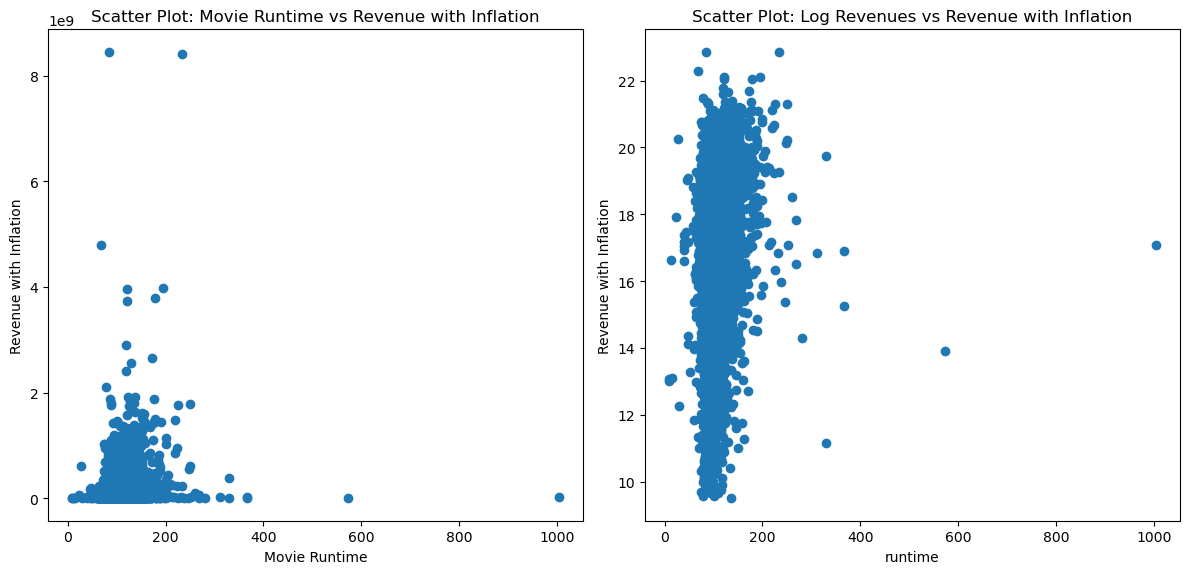

In [40]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named movie_runtime with columns 'Movie runtime', 'log_revenues', and 'Revenue with inflation'

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for 'Movie runtime' vs 'Revenue with inflation'
axes[0].scatter(movie_runtime['Movie runtime'], movie_runtime['Revenue with inflation'])
axes[0].set_xlabel('Movie Runtime')
axes[0].set_ylabel('Revenue with Inflation')
axes[0].set_title('Scatter Plot: Movie Runtime vs Revenue with Inflation')

# Scatter plot for 'log_revenues' vs 'Revenue with inflation'
axes[1].scatter(movie_runtime['Movie runtime'], movie_runtime['log_revenues'])
axes[1].set_xlabel('runtime')
axes[1].set_ylabel('Revenue with Inflation')
axes[1].set_title('Scatter Plot: Log Revenues vs Revenue with Inflation')

# Adjust layout for better presentation
plt.tight_layout()

# Show the plots
plt.show()


In [61]:
# Create a new column for intervals
movie_runtime['Interval'] = pd.cut(movie_runtime['Movie runtime'], bins=[0, 50, 100, 150, 200,250,1000], labels=['0-50', '51-100', '101-150','150-200' ,'201-250','251-1000'])
movie_runtime

,Movie runtime,log_revenues,Revenue with inflation,Interval
0,98.0,16.957621,2.315268e+07,51-100
1,123.0,17.698161,4.855272e+07,101-150
2,103.0,15.838345,7.559723e+06,101-150
3,87.0,18.583094,1.176346e+08,51-100
4,113.0,19.267046,2.331158e+08,101-150
...,...,...,...,...
8319,75.0,16.620940,1.653418e+07,51-100
8320,147.0,18.002850,6.584737e+07,101-150
8321,105.0,18.264864,8.557164e+07,101-150
8322,98.0,16.970237,2.344663e+07,51-100


/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_2481/1823593908.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x='Interval', y='Revenue with inflation', data=movie_runtime, ci=95, capsize=.2, palette='viridis', ax=ax1)


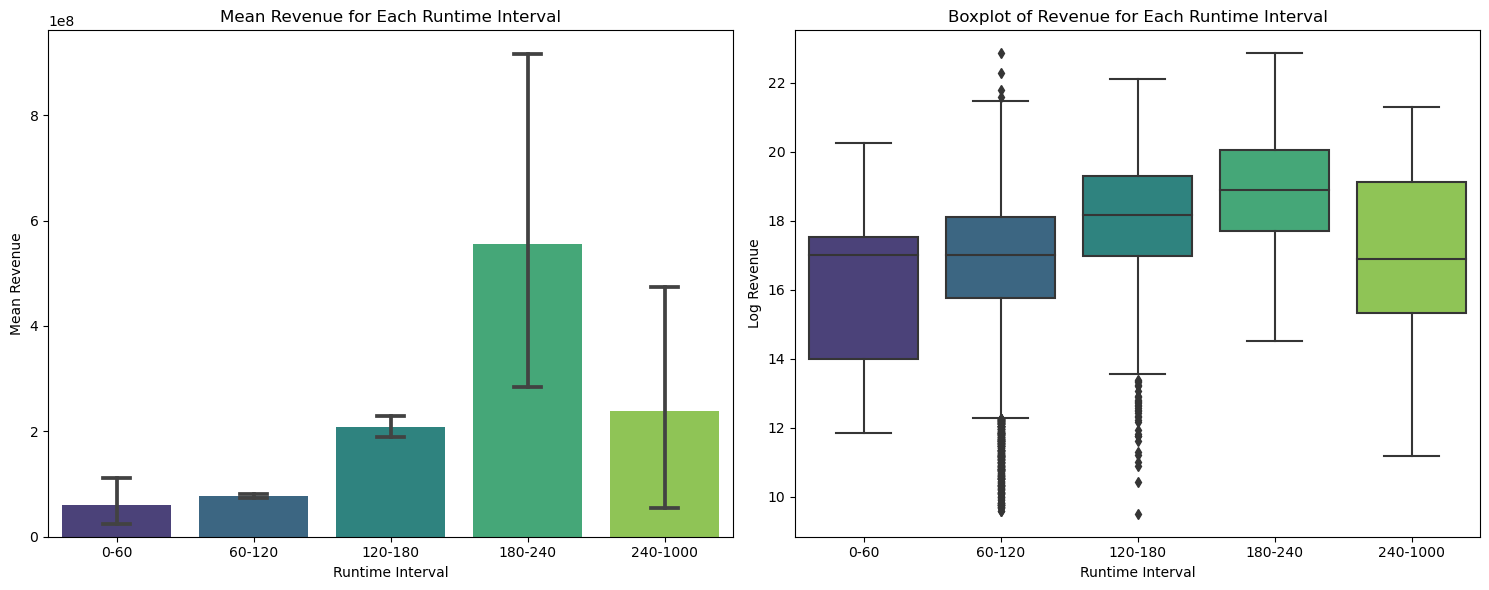

In [69]:
# Define interval_range
#interval_range = [(0, 50), (51, 100), (101, 150), (200, 1000)]

# Create a new column for intervals
movie_runtime['Interval'] = pd.cut(movie_runtime['Movie runtime'], bins=[0, 60, 120, 180, 240, 1000], labels=['0-60', '60-120', '120-180', '180-240', '240-1000'])

# Set up a multi-plot grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the mean revenue with error bars and 95% confidence interval
sns.barplot(x='Interval', y='Revenue with inflation', data=movie_runtime, ci=95, capsize=.2, palette='viridis', ax=ax1)
ax1.set_title('Mean Revenue for Each Runtime Interval')
ax1.set_xlabel('Runtime Interval')
ax1.set_ylabel('Mean Revenue')

# Plot the boxplot
sns.boxplot(x='Interval', y='log_revenues', data=movie_runtime, palette='viridis', ax=ax2)
ax2.set_title('Boxplot of Revenue for Each Runtime Interval')
ax2.set_xlabel('Runtime Interval')
ax2.set_ylabel('Log Revenue')

plt.tight_layout()
plt.show()

The data that has extreme values and outliers, we use a log scale on the x-axis to show the patterns in the majority of the data more clearly.

The data is normally distributed which gives us a idea about how we are going to seperate it in different groups

In [70]:
# Rename the column
movie_runtime = movie_runtime.rename(columns={'Revenue with inflation': 'Revenue_with_inflation', 'Movie runtime': 'movie_runtime'})

mod_runtime = smf.ols(formula='log_revenues ~ movie_runtime', data=movie_runtime)
res_runtime = mod_runtime.fit()
print(res_runtime.summary())

# Pearson correlation
correlation_coefficient, p_value_correlation = stats.pearsonr((movie_runtime["log_revenues"]), movie_runtime["movie_runtime"])
print(f'Pearson Correlation Coefficient: {correlation_coefficient}')
print(f'p-value: {p_value_correlation}')

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     393.0
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           1.75e-85
Time:                        11:39:22   Log-Likelihood:                -17756.
No. Observations:                8242   AIC:                         3.552e+04
Df Residuals:                    8240   BIC:                         3.553e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        14.8592      0.106    140.512

The Pearson correlation coefficient is approximately 0.21. This value is a measure of the strength and direction of a linear relationship between x and y. The p-value associated with the correlation coefficient is very close to zero (1.75e-85) which indicates that the correlation is statistically significant.

The results collectively suggest that there is a statistically significant but weak positive correlation between x and y. The low p-values for the Pearson correlation indicates that the correlation is unlikely to be due to random chance. However, the correlation coefficient of 0.21 suggests that the relationship is not very strong. So we can ignore this vriable for predicting the revenue

# Genre analysis

In [72]:
movie_genres_df

,Movie Genres,log_revenues,Revenue with inflation
0,"[Thriller, Science Fiction, Horror, Adventure,...",16.957621,2.315268e+07
1,"[Crime Fiction, Drama, Coming of age]",17.698161,4.855272e+07
2,"[Romantic comedy, Indie, Slice of life story, ...",15.838345,7.559723e+06
3,"[Romantic comedy, Romance Film, Fantasy, Comedy]",18.583094,1.176346e+08
4,"[Romantic comedy, Fantasy, Comedy, Drama, Roma...",19.267046,2.331158e+08
...,...,...,...
8321,"[Musical, Melodrama, Drama, Musical Drama, Bla...",18.264864,8.557164e+07
8322,"[Silent film, Melodrama, Drama, Film adaptatio...",16.970237,2.344663e+07
8323,[Silent film],17.571717,4.278582e+07
8324,"[Silent film, Indie, Black-and-white, Drama, R...",17.186055,2.909436e+07


In [73]:
# Create an empty list to store DataFrames
dfs = []

# Iterate through each row of the original DataFrame
for idx, row in movie_genres_df.iterrows():
    
    # For each genre in the 'Movie Genres' column of the current row
    for genre in row['Movie Genres']:
        
        # Create a new DataFrame with 'Genre' and 'Revenue' columns
        # Duplicate the data for each genre, using the revenue from the original row
        dfs.append(pd.DataFrame({'Genres': [genre], 'Revenue': [row['Revenue with inflation']]}))

# Concatenate the list of DataFrames into a single DataFrame
movie_genres_df_grouped = pd.concat(dfs, ignore_index=True)

# Group the concatenated DataFrame by 'Genres' and aggregate 'Revenue' using mean and count
movie_genres_df_grouped = movie_genres_df_grouped.groupby('Genres')['Revenue'].agg({'mean', 'count'}).reset_index()

# Sort the grouped DataFrame by the count of each genre in descending order
movie_genres_df_grouped = movie_genres_df_grouped.sort_values(by='count', ascending=False)

# Display the final grouped and sorted DataFrame
display(movie_genres_df_grouped)


,Genres,mean,count
103,Drama,9.017128e+07,4299
67,Comedy,9.667684e+07,3178
246,Romance Film,1.031879e+08,2033
295,Thriller,1.303342e+08,1958
2,Action,1.688885e+08,1754
...,...,...,...
143,Gay pornography,4.835392e+04,1
76,Coming-of-age film,6.780666e+08,1
136,Filmed Play,4.932388e+07,1
282,Supermarionation,7.886877e+07,1


In [74]:
# Set a threshold count for the number of movies in a genre
threshold = 500

# Select genres with a count greater than the threshold
top_movie_genres_df = movie_genres_df_grouped[movie_genres_df_grouped["count"] > threshold]

# Select genres with a count less than or equal to the threshold
other_movie_genre = movie_genres_df_grouped[movie_genres_df_grouped["count"] <= threshold]

# Display the DataFrame containing genres with counts above the threshold
top_movie_genres_df


,Genres,mean,count
103,Drama,9.017128e+07,4299
67,Comedy,9.667684e+07,3178
246,Romance Film,1.031879e+08,2033
295,Thriller,1.303342e+08,1958
2,Action,1.688885e+08,1754
5,Action/Adventure,1.570886e+08,1361
88,Crime Fiction,9.955816e+07,1278
8,Adventure,2.183305e+08,1165
172,Indie,3.039054e+07,1050
247,Romantic comedy,8.386298e+07,894


/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_2481/2746919351.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x='Genres', y='mean', data=top_movie_genres_df, ci=95, capsize=.2, palette=colors, ax=ax)


<Figure size 1200x600 with 0 Axes>

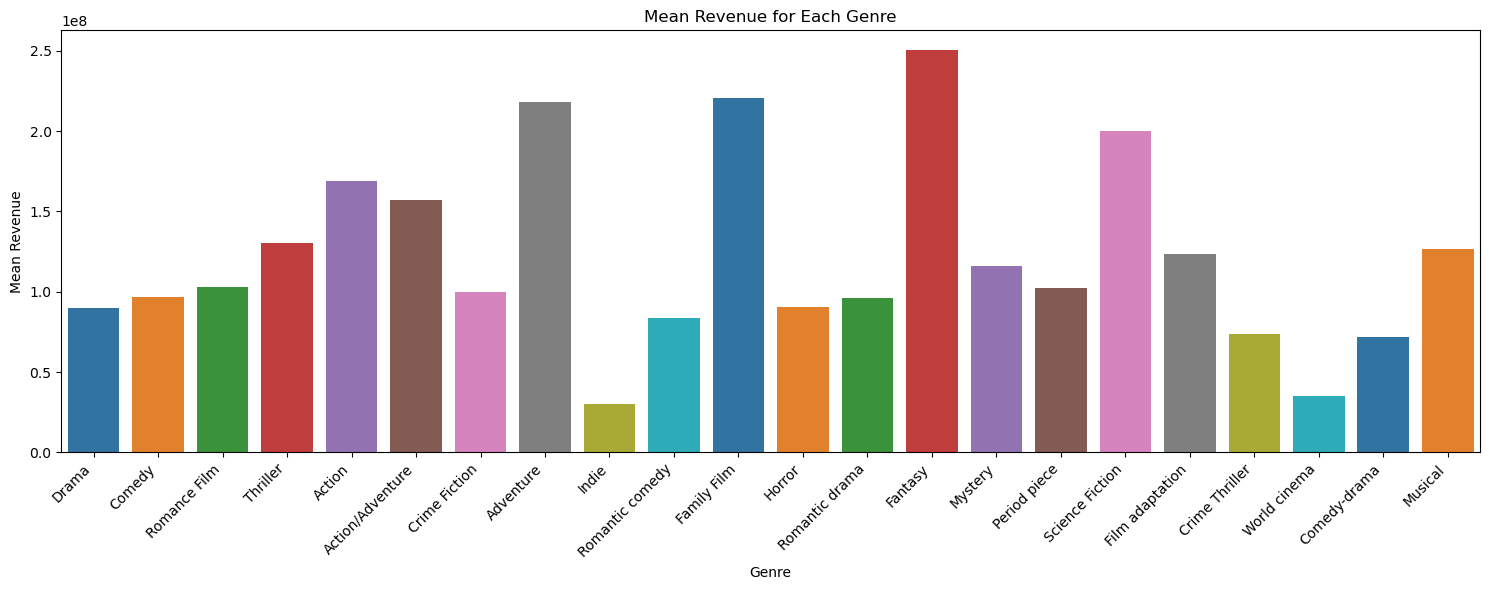

In [82]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for the plot
plt.figure(figsize=(12, 6))

# Use different colors for each genre (using the 'tab10' color map)
colors = plt.cm.tab10.colors

# Set up a multi-plot grid
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# Plot the mean revenue with error bars and 95% confidence interval
sns.barplot(x='Genres', y='mean', data=top_movie_genres_df, ci=95, capsize=.2, palette=colors, ax=ax)

# Set labels for the x-axis and y-axis
ax.set_xlabel('Genre')
ax.set_ylabel('Mean Revenue')

# Set the title of the plot
ax.set_title('Mean Revenue for Each Genre')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()


The mean revenue per genre varies significantly between genres where we find that "indie" and "World cinema" have very low mean revenues while "Fantasy", "Adventure", "Family Film" and "Science Fiction" have high mean revenues. The mean revenue of "Fantasy" genre is approximately 10 times more than the "indie" genre mean revenue.

In [83]:
# List of genres you are considering
list_of_genres = np.array(top_movie_genres_df['Genres'])

# Calculate the average revenue of genres not in the list
others_revenue = (np.sum(other_movie_genre['mean']* other_movie_genre['count'])) / other_movie_genre['count'].sum()

# Calculate the counts of genres not in the list
others_count = other_movie_genre['count'].sum()

# Create a new row for 'Others' with the calculated average revenue
others_row = pd.DataFrame({'Genres': ['Others'], 'count': [others_count], 'mean': [others_revenue]})

# Concatenate the new row to the existing DataFrame
movie_genres_categories = pd.concat([top_movie_genres_df, others_row], ignore_index=True)

# Display the updated DataFrame
movie_genres_categories

,Genres,mean,count
0,Drama,9.017128e+07,4299
1,Comedy,9.667684e+07,3178
2,Romance Film,1.031879e+08,2033
3,Thriller,1.303342e+08,1958
4,Action,1.688885e+08,1754
5,Action/Adventure,1.570886e+08,1361
6,Crime Fiction,9.955816e+07,1278
7,Adventure,2.183305e+08,1165
8,Indie,3.039054e+07,1050
9,Romantic comedy,8.386298e+07,894


/var/folders/rm/rt_43b293mv9fnxz5pb_wdd00000gn/T/ipykernel_2481/423646305.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x='Genres', y='mean', data=movie_genres_categories, ci=95, capsize=.2, palette=colors, ax=ax)


<Figure size 1200x600 with 0 Axes>

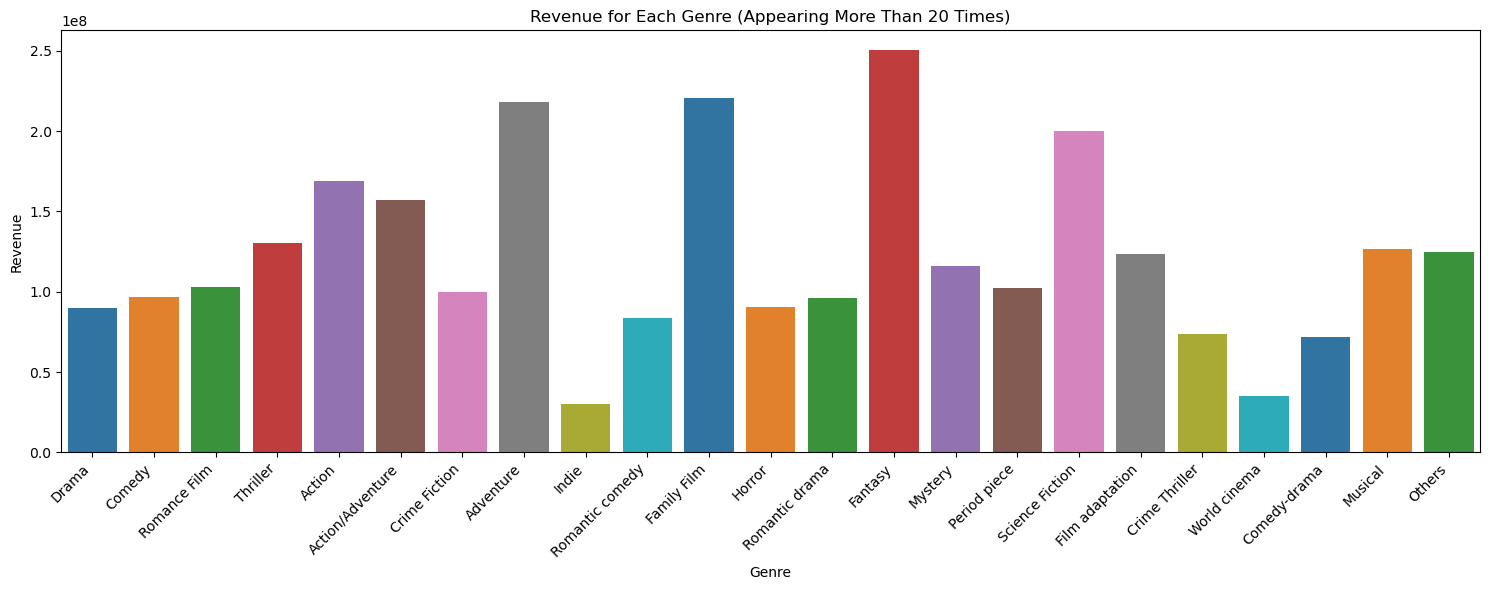

In [89]:
# Plotting
plt.figure(figsize=(12, 6))
# Use different colors for each genre
colors = plt.cm.tab10.colors

# Set up a multi-plot grid
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# Create a bar plot
sns.barplot(x='Genres', y='mean', data=movie_genres_categories, ci=95, capsize=.2, palette=colors, ax=ax)
plt.xlabel('Genre')
plt.ylabel('Revenue')
plt.title('Revenue for Each Genre (Appearing More Than 20 Times)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

The other genres represente a significant mean revenue which is close to half the mean revenue of the "Fantasy" genre.

# modifying the data

In [90]:
# Function to replace values not in the list
def replace_genres(genre_list):
    # Check if each genre in the list is in the predefined list_of_genres
    # If yes, keep the genre; otherwise, replace it with 'Other'
    return [genre if genre in list_of_genres else 'Others' for genre in genre_list]

# Apply the custom function to create a new column "primary genres"
# This column will contain the original genres if they are in list_of_genres,
# and 'Other' if they are not
movie_genres_df["primary genres"] = movie_genres_df["Movie Genres"].apply(replace_genres)

# Display the DataFrame with the new "primary genres" column
movie_genres_df


,Movie Genres,log_revenues,Revenue with inflation,primary genres
0,"[Thriller, Science Fiction, Horror, Adventure,...",16.957621,2.315268e+07,"[Thriller, Science Fiction, Horror, Adventure,..."
1,"[Crime Fiction, Drama, Coming of age]",17.698161,4.855272e+07,"[Crime Fiction, Drama, Others]"
2,"[Romantic comedy, Indie, Slice of life story, ...",15.838345,7.559723e+06,"[Romantic comedy, Indie, Others, Others, Comed..."
3,"[Romantic comedy, Romance Film, Fantasy, Comedy]",18.583094,1.176346e+08,"[Romantic comedy, Romance Film, Fantasy, Comedy]"
4,"[Romantic comedy, Fantasy, Comedy, Drama, Roma...",19.267046,2.331158e+08,"[Romantic comedy, Fantasy, Comedy, Drama, Roma..."
...,...,...,...,...
8321,"[Musical, Melodrama, Drama, Musical Drama, Bla...",18.264864,8.557164e+07,"[Musical, Others, Drama, Others, Others]"
8322,"[Silent film, Melodrama, Drama, Film adaptatio...",16.970237,2.344663e+07,"[Others, Others, Drama, Film adaptation, Roman..."
8323,[Silent film],17.571717,4.278582e+07,[Others]
8324,"[Silent film, Indie, Black-and-white, Drama, R...",17.186055,2.909436e+07,"[Others, Indie, Others, Drama, Romantic drama,..."


In [91]:
# Create a copy of the original DataFrame to avoid modifying the original data
movie_genres_df_oh = movie_genres_df.copy()

# Iterate through each genre in the predefined movie_genres_categories
for name in movie_genres_categories["Genres"]:
    print(name)
    # Create a new column with a name based on the genre, replacing spaces with underscores
    # The new column will have a value of 1 if the genre is present in the "Movie Genres" column, and 0 otherwise
    movie_genres_df_oh[f'{name.replace(" ", "_")}'] = movie_genres_df['primary genres'].apply(lambda x: 1 if name in x else 0)

# Display the DataFrame with the new one-hot encoded columns
movie_genres_df_oh


Drama
Comedy
Romance Film
Thriller
Action
Action/Adventure
Crime Fiction
Adventure
Indie
Romantic comedy
Family Film
Horror
Romantic drama
Fantasy
Mystery
Period piece
Science Fiction
Film adaptation
Crime Thriller
World cinema
Comedy-drama
Musical
Others


,Movie Genres,log_revenues,Revenue with inflation,primary genres,Drama,Comedy,Romance_Film,Thriller,Action,Action/Adventure,...,Fantasy,Mystery,Period_piece,Science_Fiction,Film_adaptation,Crime_Thriller,World_cinema,Comedy-drama,Musical,Others
0,"[Thriller, Science Fiction, Horror, Adventure,...",16.957621,2.315268e+07,"[Thriller, Science Fiction, Horror, Adventure,...",0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
1,"[Crime Fiction, Drama, Coming of age]",17.698161,4.855272e+07,"[Crime Fiction, Drama, Others]",1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,"[Romantic comedy, Indie, Slice of life story, ...",15.838345,7.559723e+06,"[Romantic comedy, Indie, Others, Others, Comed...",1,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,"[Romantic comedy, Romance Film, Fantasy, Comedy]",18.583094,1.176346e+08,"[Romantic comedy, Romance Film, Fantasy, Comedy]",0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"[Romantic comedy, Fantasy, Comedy, Drama, Roma...",19.267046,2.331158e+08,"[Romantic comedy, Fantasy, Comedy, Drama, Roma...",1,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8321,"[Musical, Melodrama, Drama, Musical Drama, Bla...",18.264864,8.557164e+07,"[Musical, Others, Drama, Others, Others]",1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
8322,"[Silent film, Melodrama, Drama, Film adaptatio...",16.970237,2.344663e+07,"[Others, Others, Drama, Film adaptation, Roman...",1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
8323,[Silent film],17.571717,4.278582e+07,[Others],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8324,"[Silent film, Indie, Black-and-white, Drama, R...",17.186055,2.909436e+07,"[Others, Indie, Others, Drama, Romantic drama,...",1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [92]:
movie_genres_df_oh.columns

Index(['Movie Genres', 'log_revenues', 'Revenue with inflation',
       'primary genres', 'Drama', 'Comedy', 'Romance_Film', 'Thriller',
       'Action', 'Action/Adventure', 'Crime_Fiction', 'Adventure', 'Indie',
       'Romantic_comedy', 'Family_Film', 'Horror', 'Romantic_drama', 'Fantasy',
       'Mystery', 'Period_piece', 'Science_Fiction', 'Film_adaptation',
       'Crime_Thriller', 'World_cinema', 'Comedy-drama', 'Musical', 'Others'],
      dtype='object')

In [93]:
# Rename the 'Revenue with inflation' column for better compatibility with the formula
movie_genres_df_oh = movie_genres_df_oh.rename(columns={'Revenue with inflation': 'Revenue_with_inflation'})

# Define the linear regression model using the formula
mod = smf.ols(formula='log_revenues ~ Drama + Comedy + Romance_Film + Thriller + Action + Action/Adventure + Crime_Fiction + \
               Adventure + Indie + Romantic_comedy + Family_Film + Horror + Romantic_drama + Fantasy + Mystery + Period_piece + \
               Science_Fiction + Film_adaptation + Crime_Thriller + World_cinema + Others', data=movie_genres_df_oh)

# Fit the linear regression model to the data
res = mod.fit()

# Print the summary of the regression results
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     100.0
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        11:53:11   Log-Likelihood:                -17210.
No. Observations:                8326   AIC:                         3.446e+04
Df Residuals:                    8304   BIC:                         3.462e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           15.9427      0.065  

In [94]:
all_genres = ['Drama', 'Comedy', 'Romance_Film', 'Thriller',
       'Action', 'Action/Adventure', 'Crime_Fiction', 'Adventure', 'Indie',
       'Romantic_comedy', 'Family_Film', 'Horror', 'Romantic_drama', 'Fantasy',
       'Mystery', 'Period_piece', 'Science_Fiction', 'Film_adaptation',
       'Crime_Thriller', 'World_cinema', 'Comedy-drama', 'Musical', 'Others']

genres_to_drop = []

for i, genre in enumerate(all_genres):
    first = movie_genres_df_oh[movie_genres_df_oh[genre]==1]
    second = movie_genres_df_oh[movie_genres_df_oh[genre]==0]
    # Pearson correlation
    t_stat, p_value = stats.ttest_ind((first["log_revenues"]), second["log_revenues"])
    if (p_value > 0.01):
        genres_to_drop.append(genre)
    else:
       print(f't_stat {genre}: {t_stat} and p-value: {p_value}')

print(genres_to_drop)
   

t_stat Drama: -8.425092901930954 and p-value: 4.207672856364986e-17
t_stat Comedy: 5.174346195333519 and p-value: 2.340471290912355e-07
t_stat Thriller: 10.708897387483914 and p-value: 1.3768254476851234e-26
t_stat Action: 18.414378216542925 and p-value: 2.9654377193591416e-74
t_stat Action/Adventure: 15.511339533593937 and p-value: 1.6237748880537242e-53
t_stat Adventure: 18.70212571336958 and p-value: 1.7323605717214215e-76
t_stat Indie: -27.68303123807408 and p-value: 1.9401422561550553e-161
t_stat Family_Film: 15.626149906321233 and p-value: 2.83872717951908e-54
t_stat Fantasy: 14.034394983919618 and p-value: 3.058923466136424e-44
t_stat Mystery: 4.605828137864348 and p-value: 4.169295998663686e-06
t_stat Science_Fiction: 10.487560699977552 and p-value: 1.4218909501800835e-25
t_stat Film_adaptation: 3.9995632041049136 and p-value: 6.400860141375583e-05
t_stat World_cinema: -11.932348475124156 and p-value: 1.4780931699535728e-32
t_stat Comedy-drama: -4.165011577604643 and p-value: 3

# Named Entity Recognition (NER): + SCORES

In [ ]:
# Create a copy of the summary dataset
movie_summaries_ner = plot_summaries_df.copy()
movie_summaries_ner["Movie Summary"] = movie_summaries_ner["Movie Summary"].astype("string")

# Extract each column in a new Series variables
Movie_IDs = movie_summaries_ner["Movie ID"].squeeze()
Movie_Summaries = movie_summaries_ner["Movie Summary"].squeeze()

#Check uniqueness of values in each Series variable
print(Movie_IDs.duplicated().sum()) # contains 0 duplicate values
print(Movie_Summaries.duplicated().sum()) # contains 8 duplicate values

#Remove duplicate values
movie_summaries_ner = movie_summaries_ner.drop_duplicates("Movie Summary")
print(summary_metadata.shape)

0
8
(42295, 4)


In [ ]:
# Imports, data folders and necessary requirements
import spacy
from spacy.lang.en.examples import sentences
from collections import Counter

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

In [ ]:
movie_summaries_ner

,Movie ID,Movie Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


In [ ]:
# Function to extract NER and count frequencies
def extract_ner_frequencies(text):
    doc = nlp(text)
    ner_frequencies = {}
    for ent in doc.ents:
        if ent.label_ not in ner_frequencies:
            ner_frequencies[ent.label_] = 1
        else:
            ner_frequencies[ent.label_] += 1
    return ner_frequencies

In [ ]:
# Apply the function to the 'Movie Summary' column
movie_summaries_ner['ner_frequencies'] = movie_summaries_ner['Movie Summary'].apply(extract_ner_frequencies)
movie_summaries_ner

,Movie ID,Movie Summary,ner_frequencies
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",{'PERSON': 1}
1,31186339,The nation of Panem consists of a wealthy Capi...,"{'ORG': 31, 'CARDINAL': 5, 'DATE': 9, 'EVENT':..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"{'PERSON': 27, 'DATE': 3, 'GPE': 23, 'ORG': 6,..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","{'GPE': 6, 'PERSON': 32, 'MONEY': 2, 'DATE': 9..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"{'DATE': 6, 'ORG': 3, 'PERSON': 13, 'CARDINAL'..."
...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","{'PERSON': 1, 'NORP': 1, 'GPE': 1, 'ORG': 1, '..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","{'DATE': 4, 'GPE': 7, 'PERSON': 14, 'FAC': 1, ..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,"{'NORP': 1, 'ORG': 1, 'DATE': 2, 'PERSON': 3, ..."
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","{'PERSON': 16, 'GPE': 3, 'NORP': 1, 'CARDINAL'..."


In [ ]:
# Create new columns for each NER category
ner_categories = set(category for ner_frequencies in movie_summaries_ner['ner_frequencies'] for category in ner_frequencies)
for category in ner_categories:
    movie_summaries_ner[category] = movie_summaries_ner['ner_frequencies'].apply(lambda x: x.get(category, 0))

# Drop the temporary 'ner_frequencies' column
movie_summaries_ner = movie_summaries_ner.drop(columns=['ner_frequencies'])

movie_summaries_ner

,Movie ID,Movie Summary,LOC,FAC,LAW,PERCENT,CARDINAL,PERSON,LANGUAGE,QUANTITY,NORP,ORG,DATE,EVENT,WORK_OF_ART,TIME,ORDINAL,MONEY,PRODUCT,GPE
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,31186339,The nation of Panem consists of a wealthy Capi...,1,3,0,0,5,21,0,0,0,31,9,2,4,2,1,0,2,3
2,20663735,Poovalli Induchoodan is sentenced for six yea...,0,0,0,0,0,27,0,0,4,6,3,0,0,0,1,0,2,23
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",0,0,0,0,0,32,0,0,1,13,9,1,1,2,1,2,0,6
4,595909,Seventh-day Adventist Church pastor Michael Ch...,1,0,0,0,1,13,1,0,0,3,6,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...",0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,1
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...",0,1,0,0,3,14,0,0,1,2,4,1,0,0,0,0,0,7
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,0,0,0,0,0,3,0,0,1,1,2,0,0,0,1,0,0,0
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",0,0,0,0,1,16,0,0,1,0,2,0,0,0,0,0,0,3


In [ ]:
movie_df

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie Languages,Movie Countries,Movie Genres,Year,Month
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,8.0
7,10408933,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938,8.0
13,171005,Henry V,1989-11-08,10161099.0,137.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",1989,11.0
17,77856,Mary Poppins,1964-08-27,102272727.0,139.0,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",1964,8.0
21,612710,New Rose Hotel,1999-10-01,21521.0,92.0,[English Language],[United States of America],"[Thriller, Science Fiction, Future noir, Indie...",1999,10.0
...,...,...,...,...,...,...,...,...,...,...
81695,54540,Coming to America,1988-06-29,288752301.0,117.0,[English Language],[United States of America],"[Romantic comedy, Comedy of manners, Drama, Co...",1988,6.0
81720,7761830,Spaced Invaders,1990,15369573.0,100.0,[English Language],[United States of America],"[Alien Film, Science Fiction, Family Film, Com...",1990,NaN
81725,1918494,State and Main,2000-08-26,6944471.0,106.0,"[Italian Language, English Language]","[France, United States of America]","[Parody, Americana, Comedy]",2000,8.0
81726,664006,Guilty as Sin,1993-06-04,22886222.0,107.0,[],[United States of America],"[Thriller, Erotic thriller, Psychological thri...",1993,6.0


In [ ]:
movie_revenue_df = movie_with_inflation[["Wikipedia movie ID","Revenue with inflation","log_revenues"]].copy()
movie_revenue_df = movie_revenue_df.rename(columns={"Wikipedia movie ID":"Movie ID"})

# Merge the dataframes based on the "Wikipedia movie ID"
movie_summary_metadata_ner = pd.merge(movie_revenue_df, movie_summaries_ner, on="Movie ID", how='outer')

# Drop NAN values
movie_summary_metadata_ner.dropna(inplace=True)

movie_summary_metadata_ner.columns

Index(['Movie ID', 'Revenue with inflation', 'log_revenues', 'Movie Summary',
       'LOC', 'FAC', 'LAW', 'PERCENT', 'CARDINAL', 'PERSON', 'LANGUAGE',
       'QUANTITY', 'NORP', 'ORG', 'DATE', 'EVENT', 'WORK_OF_ART', 'TIME',
       'ORDINAL', 'MONEY', 'PRODUCT', 'GPE'],
      dtype='object')

In [ ]:
# Rename the column
movie_summary_metadata_ner = movie_summary_metadata_ner.rename(columns={'Revenue with inflation': 'Revenue_with_inflation'})

mod_ner = smf.ols(formula='Revenue_with_inflation ~ LOC + FAC + LAW + PERCENT + CARDINAL + PERSON + LANGUAGE + QUANTITY +\
    NORP + ORG + DATE + EVENT + WORK_OF_ART + TIME + ORDINAL + MONEY + PRODUCT + GPE', data=movie_summary_metadata_ner)
res_ner = mod_ner.fit()
print(res_ner.summary())

                              OLS Regression Results                              
Dep. Variable:     Revenue_with_inflation   R-squared:                       0.075
Model:                                OLS   Adj. R-squared:                  0.073
Method:                     Least Squares   F-statistic:                     33.89
Date:                    Sun, 03 Dec 2023   Prob (F-statistic):          4.54e-113
Time:                            20:28:39   Log-Likelihood:            -1.5641e+05
No. Observations:                    7528   AIC:                         3.129e+05
Df Residuals:                        7509   BIC:                         3.130e+05
Df Model:                              18                                         
Covariance Type:                nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept 

OLS INTERPRETATION TO BE ADDED